In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

In [2]:
import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats

import seaborn as sns

In [3]:
def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['reward', 'time'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [4]:
#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [5]:
def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type', 'time', 'reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [6]:
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [7]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

In [8]:
#version is 's' for single player and 'j' for joint
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    if version == 'j':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff
    if version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff
    return p1_g1, p1_g2, p1_score_diff

In [9]:
#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    #df_p1_g1 = df_p1_g1[20:40]
    #remove trials for g2
    #df_p1_g2 = df_p1_g2[20:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
   # df_p2_g1 = df_p2_g1[20:40]
    #remove trials for g2
    #df_p2_g2= df_p2_g2[20:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [10]:
#notes from Binghong:

#see reshape to restrict csv file size
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
#https://www.w3schools.com/python/numpy_array_shape.asp 
#https://stackoverflow.com/

#use drop to filter data frames or cut
#Df=df[20:]

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html 
#drop columns, python, df

# ANOVA

In [11]:
import pingouin as pg

# Single Player Analysis

In [12]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff = call_get_score(s01, 's')
s01.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,60,2,1
3,1,2,2,1,90,2,2
4,1,3,1,2,30,2,2


In [13]:
#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/s02_gamedata.csv')
#s02 = df
#s02_p1_g1_score = get_score(s02, 1, 1)
#s02.head()

In [14]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff = call_get_score(s03, 's')
s03.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,1,90,2,2


In [15]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff = call_get_score(s05, 's')
s05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,90,2,1
3,1,2,2,1,90,2,2
4,1,3,1,3,90,3,2


In [16]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff = call_get_score(s06, 's')
s06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,1,0
1,1,1,2,1,90,1,1
2,1,2,1,2,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,3,90,2,2


In [17]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff = call_get_score(s07, 's')
s07.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,1,90,0,1
2,1,2,1,3,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,1,90,1,2


In [18]:
pd.set_option('display.max_columns', None)  

In [19]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff = call_get_score(s08, 's')
s08.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,90,1,1
3,1,2,2,1,90,1,2
4,1,3,1,2,90,2,2


In [20]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff = call_get_score(s09, 's')
s09.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,60,2,1
3,1,2,2,1,90,2,1
4,1,3,1,1,90,3,1


In [21]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s11_gamedata.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff = call_get_score(s11, 's')
s11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,1,30,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,60,1,2


In [22]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff = call_get_score(s12, 's')
s12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,30,1,1
3,1,2,2,2,60,1,2
4,1,3,1,1,90,2,2


In [23]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s15_gamedata.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff = call_get_score(s15, 's')
s15.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,1,30,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,90,1,2


In [24]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s16_gamedata.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff = call_get_score(s16, 's')
s16.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,3,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,1,90,2,2


In [25]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff = call_get_score(s19, 's')
s19.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,1,0
1,1,1,2,1,90,1,0
2,1,2,1,1,90,2,0
3,1,2,2,1,90,2,1
4,1,3,1,3,30,2,1


In [26]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s17_gamedata.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff = call_get_score(s17, 's')
s17.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,3,60,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,90,1,2


In [27]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff = call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2


# Single score diff between G1 and G2

In [28]:
score_diff = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_diff':
     [s01_score_diff, s03_score_diff, s05_score_diff, s06_score_diff,
      s07_score_diff, s08_score_diff, s09_score_diff, s11_score_diff, s12_score_diff, s15_score_diff, s16_score_diff, s17_score_diff, s19_score_diff, s20_score_diff]})

In [29]:
score_diff

,participant,score_diff
0,s01,14
1,s03,8
2,s05,11
3,s06,5
4,s07,5
5,s08,-10
6,s09,5
7,s11,1
8,s12,3
9,s15,15


In [30]:
score_diff_mean = score_diff['score_diff'].mean()

In [31]:
score_diff_mean

4.0

# Single scores in G1 and G2

In [32]:
#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#print
s_scores_1

,score_1
participant,
s01,60
s03,63
s05,77
s06,82
s07,63
s08,90
s09,65
s11,60
s12,83


In [33]:
#list out all the scores in game 2 by participant
s_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)
s_scores_2

,score_2
participant,
s01,74
s03,71
s05,88
s06,87
s07,68
s08,80
s09,70
s11,61
s12,86


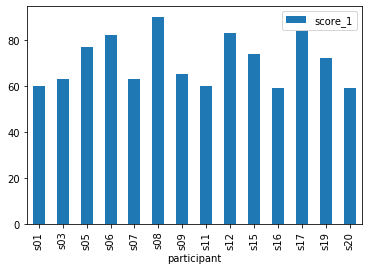

In [34]:
s_scores_1_bar = s_scores_1.plot.bar()

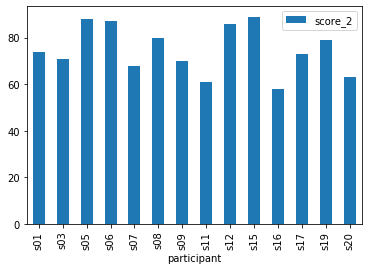

In [35]:
s_scores_2_bar = s_scores_2.plot.bar()

In [36]:
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

In [37]:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')
#label columns
s_scores.columns=['Game 1','Game 2']

In [38]:
s_scores

,Game 1,Game 2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


([<matplotlib.axis.YTick at 0x1c27df6650>,
 <a list of 6 Text yticklabel objects>)

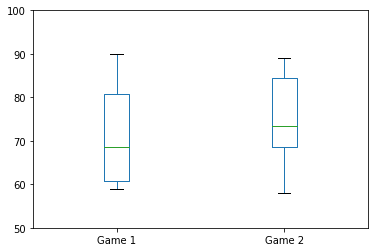

In [39]:
s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
plt.grid(b=None)
plt.yticks(np.arange(50, 105, step=10))

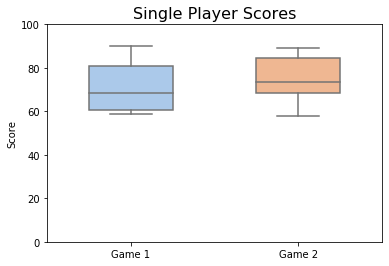

In [40]:
s_scores_box = sns.boxplot( 
                 data=s_scores, 
                 width=0.5,
                 palette="pastel")
s_scores_box.axes.set_title("Single Player Scores",
                    fontsize=16)

plot_file_name="s_score_box.jpg"
 
plt.ylim(0, 100)
s_scores_box.axes.set(ylabel='Score')

# save as jpeg
s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [41]:
s_scores_p = sp.stats.ttest_rel(s_scores['Game 1'],s_scores['Game 2'])

In [42]:
s_scores_p

Ttest_relResult(statistic=-1.96521473776207, pvalue=0.07112499604880738)

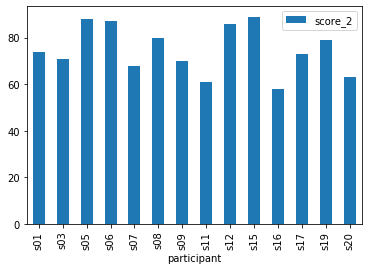

In [43]:
s_scores_2_bar = s_scores_2.plot.bar()

In [44]:
#combine g1 and g2 to one dataframe
s_combo = s_scores_1.append(s_scores_2)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [45]:
'''s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'
                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':
     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,
      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,
      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})
s_combo.set_index('participant', inplace=True, drop=True)'''

"s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'\n                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':\n     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,\n      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,\n      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})\ns_combo.set_index('participant', inplace=True, drop=True)"

In [46]:

#new_index = ('s01_g1','s01_g2','s02_g1','s03_g1','s03_g2','s05_g1','s05_g2', 
                               #'s06_g1','s06_g2','s07_g1','s07_g2','s08_g1','s08_g2','s09_g1','s09_g2')
#s_combo.index = new_index

In [47]:
s_combo = s_combo.sort_values(by=['participant'])

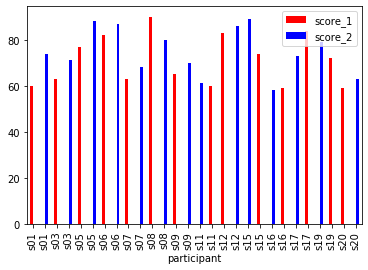

In [48]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(s_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
s_combo_bar = s_combo.plot(kind='bar',color=colors)

In [49]:
s_scores_1_mean = s_scores_1.mean()

In [50]:
s_scores_1_mean

score_1    70.785714
dtype: float64

In [51]:
s_scores_1_std = s_scores_1.std()

In [52]:
s_scores_1_std

score_1    10.864045
dtype: float64

In [53]:
s_scores_2_mean = s_scores_2.mean()

In [54]:
s_scores_2_mean

score_2    74.785714
dtype: float64

In [55]:
s_scores_2_std = s_scores_2.std()

In [56]:
s_scores_2_std

score_2    10.356555
dtype: float64

In [57]:
s_scores_med = s_scores.median()
s_scores_med

Game 1    68.5
Game 2    73.5
dtype: float64

# Single choice probabilities

In [58]:
s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [59]:
s01_p1_g2

,game number,trial,player,arm,probability,P1 score,P2 score
200,2,1,1,2,90,1,0
202,2,2,1,3,30,2,0
204,2,3,1,1,60,2,1
206,2,4,1,2,90,3,2
208,2,5,1,2,90,4,3
...,...,...,...,...,...,...,...
390,2,96,1,2,90,70,88
392,2,97,1,2,90,71,89
394,2,98,1,3,30,72,90
396,2,99,1,1,60,73,91


In [60]:
s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [61]:
s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [62]:
#to see each individual count of probabilities, print: 
#s01_p1_g1_count

# Single choices in G1 

In [63]:
s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])

In [64]:
#How to prevent NaN: df = df.fillna(0)
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30,60,90
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,35,36
s12_p1_g1_count,7,28,65
s15_p1_g1_count,10,12,79


In [65]:
s_g1_counts.sum(axis=1)

s01_p1_g1_count    100
s03_p1_g1_count    100
s05_p1_g1_count    100
s06_p1_g1_count    100
s07_p1_g1_count    100
s08_p1_g1_count    100
s09_p1_g1_count    100
s11_p1_g1_count    101
s12_p1_g1_count    100
s15_p1_g1_count    101
s16_p1_g1_count    101
s17_p1_g1_count    101
s19_p1_g1_count    100
s20_p1_g1_count    101
dtype: int64

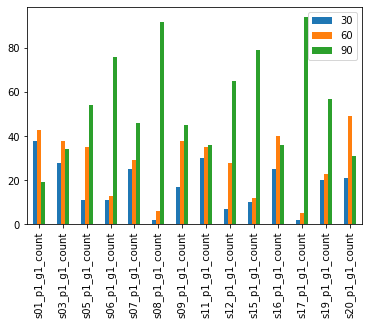

In [66]:
s_g1_counts_bar = s_g1_counts.plot.bar()

# save as jpeg
s_g1_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.6.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


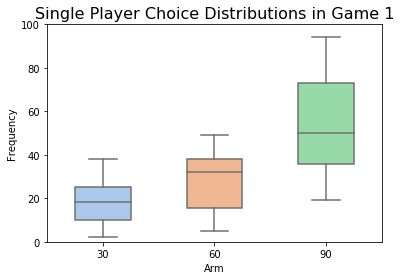

In [67]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("Single Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [68]:
#0 is low (30), 1 is med (60), 2 is high (90)
s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])

In [69]:
s_g1_low

17.642857142857142

In [70]:
s_g1_med

28.142857142857142

In [71]:
s_g1_high

54.57142857142857

In [72]:
s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [73]:
s_g1_low_std

10.519418390068251

In [74]:
s_g1_med_std

13.700141515729698

In [75]:
s_g1_high_std

22.717879320401508

# Single choices in G2

In [76]:
s_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count'])

In [77]:
#How to prevent NaN: df = df.fillna(0)
s_g2_counts = s_g2_counts.fillna(0)

#print
s_g2_counts

,30,60,90
s01_p1_g2_count,38.0,16.0,46.0
s03_p1_g2_count,27.0,29.0,44.0
s05_p1_g2_count,11.0,0.0,89.0
s06_p1_g2_count,7.0,7.0,86.0
s07_p1_g2_count,18.0,32.0,50.0
s08_p1_g2_count,9.0,15.0,76.0
s09_p1_g2_count,14.0,37.0,49.0
s11_p1_g2_count,28.0,31.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s15_p1_g2_count,3.0,7.0,91.0


In [78]:
s_g2_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
s11_p1_g2_count    101.0
s12_p1_g2_count    100.0
s15_p1_g2_count    101.0
s16_p1_g2_count    101.0
s17_p1_g2_count    101.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

In [79]:
s15_p1_g1

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,0,0
2,1,2,1,1,30,1,1
4,1,3,1,2,90,1,2
6,1,4,1,2,90,2,3
8,1,5,1,2,90,3,4
...,...,...,...,...,...,...,...
192,1,97,1,1,30,71,86
194,1,98,1,2,90,71,87
196,1,99,1,2,90,72,88
198,1,100,1,2,90,73,89


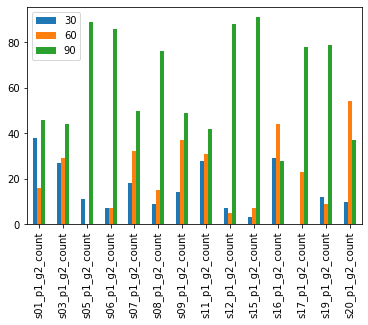

In [80]:
s_g2_counts_bar = s_g2_counts.plot.bar()

# save as jpeg
s_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

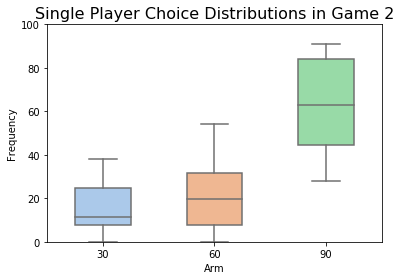

In [81]:
s_g2_counts_box = sns.boxplot( 
                 data=s_g2_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_counts_box.axes.set_title("Single Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="s_g2_counts_box.jpg"
 
plt.ylim(0, 100)
s_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [82]:
s_g2_low = np.mean(s_g2_counts.iloc[:,0])
s_g2_med = np.mean(s_g2_counts.iloc[:,1])
s_g2_high = np.mean(s_g2_counts.iloc[:,2])

In [83]:
s_g2_low

15.214285714285714

In [84]:
s_g2_med

22.071428571428573

In [85]:
s_g2_high

63.07142857142857

In [86]:
s_g2_low_std = np.std(s_g2_counts.iloc[:,0])
s_g2_med_std = np.std(s_g2_counts.iloc[:,1])
s_g2_high_std = np.std(s_g2_counts.iloc[:,2])

In [87]:
s_g2_low_std

10.791389235527234

In [88]:
s_g2_med_std

15.677391755164441

In [89]:
s_g2_high_std

21.746803659107126

# Single arrays

In [90]:
#pip install researchpy

In [91]:
import researchpy as rp

In [92]:
s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

In [93]:
s_90_1

array([19, 34, 54, 76, 46, 92, 45, 36, 65, 79, 36, 94, 57, 31])

In [94]:
s_90_2

array([46., 44., 89., 86., 50., 76., 49., 42., 88., 91., 28., 78., 79.,
       37.])

In [95]:
s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])

In [96]:
s_60_1

array([43, 38, 35, 13, 29,  6, 38, 35, 28, 12, 40,  5, 23, 49])

In [97]:
s_60_2

array([16., 29.,  0.,  7., 32., 15., 37., 31.,  5.,  7., 44., 23.,  9.,
       54.])

In [98]:
s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

In [99]:
s_30_1

array([38, 28, 11, 11, 25,  2, 17, 30,  7, 10, 25,  2, 20, 21])

In [100]:
s_30_2

array([38., 27., 11.,  7., 18.,  9., 14., 28.,  7.,  3., 29.,  0., 12.,
       10.])

# Single choice statistics

In [101]:
s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)

In [102]:
s_90_p

Ttest_relResult(statistic=-2.1007913707186128, pvalue=0.055732492138652105)

In [103]:
s_60_p

Ttest_relResult(statistic=1.55433357971267, pvalue=0.14410446381597375)

In [104]:
s_30_p

Ttest_relResult(statistic=1.8933894644584188, pvalue=0.08077710499067489)

# Confederate Player Analysis

In [105]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff = call_get_score(c02, 'c')
c02.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,30,0,1
3,1,2,2,1,90,0,2
4,1,3,1,1,90,0,2


In [106]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff = call_get_score(c03, 'c')
c03.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,1,0
1,1,1,2,3,30,1,1
2,1,2,1,2,60,1,1
3,1,2,2,3,30,1,2
4,1,3,1,1,30,1,2


In [107]:
#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/c04_gamedata.csv')
#c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff = call_get_score(c04, 'c')
#c04.head()

In [108]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff = call_get_score(c05, 'c')
c05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,0,0
1,1,1,2,3,30,0,1
2,1,2,1,1,30,1,1
3,1,2,2,3,30,1,1
4,1,3,1,3,90,2,1


In [109]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff = call_get_score(c06, 'c')
c06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,3,30,0,0
2,1,2,1,1,30,0,0
3,1,2,2,3,30,0,0
4,1,3,1,3,60,1,0


In [110]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff = call_get_score(c09, 'c')
c09.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,1,90,1,0
2,1,2,1,3,60,2,0
3,1,2,2,1,90,2,1
4,1,3,1,1,90,3,1


In [111]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff = call_get_score(c10, 'c')
c10.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,30,1,1
3,1,2,2,1,90,1,2
4,1,3,1,2,60,2,2


In [112]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff = call_get_score(c11, 'c')
c11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,1,0
1,1,1,2,2,60,1,1
2,1,2,1,1,60,1,1
3,1,2,2,2,60,1,2
4,1,3,1,1,60,1,2


In [113]:
pd.set_option('display.max_columns', None)  

In [114]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c12_gamedata.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff = call_get_score(c12, 'c')
c12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,0
3,1,3,2,0,90,2,0
4,1,4,1,3,30,2,1


In [115]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c13_gamedata.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff = call_get_score(c13, 'c')
c13.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,60,0,0
1,1,1,2,0,60,0,0
2,1,2,1,3,30,0,1
3,1,3,2,0,60,0,1
4,1,4,1,2,60,0,1


In [116]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c14_gamedata.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff = call_get_score(c14, 'c')
c14.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,0,0
1,1,1,2,0,30,0,0
2,1,2,1,3,30,0,0
3,1,3,2,0,30,0,0
4,1,4,1,2,60,0,0


In [117]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c16_gamedata.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff = call_get_score(c16, 'c')
c12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,0
3,1,3,2,0,90,2,0
4,1,4,1,3,30,2,1


In [118]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c17_gamedata.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff = call_get_score(c17, 'c')
c17.head()#in the s files, p2 is the confederate


,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,0,0
1,1,1,2,0,60,0,0
2,1,2,1,3,30,0,0
3,1,3,2,0,60,0,0
4,1,4,1,1,90,0,1


# Confederate score difference between G1 and G2

In [119]:
score_diff_confederate = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'score_diff_confederate':
     [c02_score_diff, c03_score_diff,
      c05_score_diff, c06_score_diff, c09_score_diff, c10_score_diff, c11_score_diff, c12_score_diff, c13_score_diff, c14_score_diff, c16_score_diff, c17_score_diff ]})

In [120]:
score_diff_confederate

,participant,score_diff_confederate
0,c02,11
1,c03,-6
2,c05,11
3,c06,-6
4,c09,-17
5,c10,-2
6,c11,13
7,c12,-6
8,c13,4
9,c14,-3


In [121]:
score_diff_confederate_mean = score_diff_confederate['score_diff_confederate'].mean()

In [122]:
#score_diff_ex_mean = score_diff_confederate_ex['score_diff_confederate'].mean()

In [123]:
score_diff_confederate_mean

-0.9166666666666666

In [124]:
#score_diff_ex_mean

# Confederate scores in G1 and G2

In [125]:
#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_1':
     [c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1

,confederate_score_1
participant,
c02,74
c03,79
c05,61
c06,59
c09,61
c10,81
c11,69
c12,59
c13,64


In [126]:
#list out all the scores in game 2 by participant
c_scores_2 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_2':[c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
c_scores_2

,confederate_score_2
participant,
c02,85
c03,73
c05,72
c06,53
c09,44
c10,79
c11,82
c12,53
c13,68


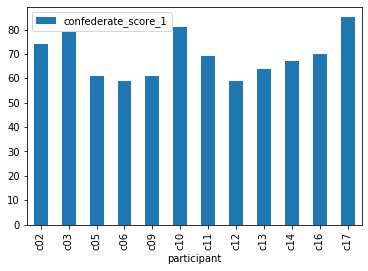

In [127]:
c_scores_1_bar = c_scores_1.plot.bar()

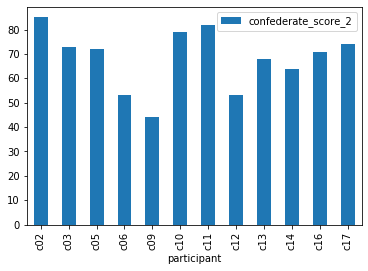

In [128]:
c_scores_2_bar = c_scores_2.plot.bar()

In [129]:
#merge both games by participant:
c_scores = pd.merge(c_scores_1, c_scores_2, on = 'participant')

In [130]:
#label columns
c_scores.columns=['Game 1','Game 2']

In [131]:
c_scores

,Game 1,Game 2
participant,,
c02,74,85
c03,79,73
c05,61,72
c06,59,53
c09,61,44
c10,81,79
c11,69,82
c12,59,53
c13,64,68


([<matplotlib.axis.YTick at 0x1c28de23d0>,
 <a list of 6 Text yticklabel objects>)

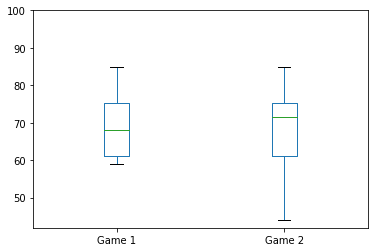

In [132]:
c_scores_box = c_scores.boxplot(labels=['Game 1','Game 2'])
plt.grid(b=None)
plt.yticks(np.arange(50, 105, step=10))

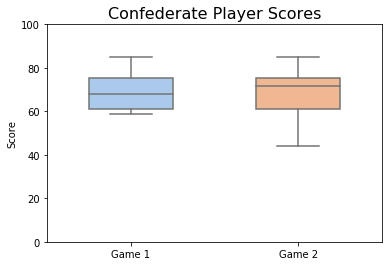

In [133]:
c_scores_box = sns.boxplot( 
                 data=c_scores, 
                 width=0.5,
                 palette="pastel")
c_scores_box.axes.set_title("Confederate Player Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [134]:
c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])

In [135]:
c_scores_p

Ttest_relResult(statistic=0.34188840128339476, pvalue=0.7388773653404721)

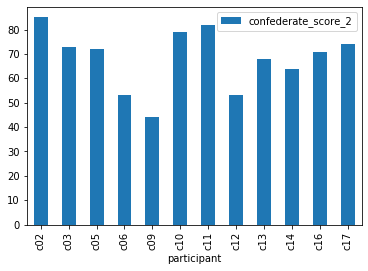

In [136]:
c_scores_2_bar = c_scores_2.plot.bar()

In [137]:
#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [138]:
'''c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)'''

"c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=True)"

In [139]:
#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index

In [140]:
c_combo = c_combo.sort_values(by=['participant'])

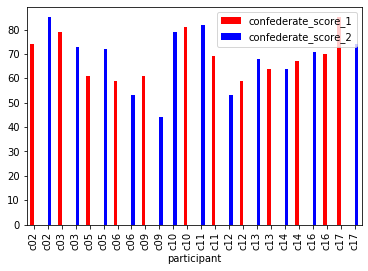

In [141]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
c_combo_bar = c_combo.plot(kind='bar',color=colors)

In [142]:
c_scores_1_mean = c_scores_1.mean()

In [143]:
c_scores_1_mean

confederate_score_1    69.083333
dtype: float64

In [144]:
c_scores_1_std = c_scores_1.std()

In [145]:
c_scores_1_std

confederate_score_1    8.959082
dtype: float64

In [146]:
c_scores_2_mean = c_scores_2.mean()

In [147]:
c_scores_2_mean

confederate_score_2    68.166667
dtype: float64

In [148]:
c_scores_2_std = c_scores_2.std()

In [149]:
c_scores_2_std

confederate_score_2    12.554125
dtype: float64

In [150]:
c_scores_med = c_scores.median()
c_scores_med

Game 1    68.0
Game 2    71.5
dtype: float64

# Confederate choice probabilities

In [151]:
#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [152]:
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)

# Confederate choices in G1

In [153]:
c_g1_counts = pd.DataFrame([c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
         index=['c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])

In [154]:
#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts

,30,60,90
c02_p1_g1_count,13,44,43
c03_p1_g1_count,12,4,84
c05_p1_g1_count,34,31,35
c06_p1_g1_count,29,29,42
c09_p1_g1_count,28,47,25
c10_p1_g1_count,9,13,78
c11_p1_g1_count,19,38,43
c12_p1_g1_count,34,47,20
c13_p1_g1_count,24,34,43
c14_p1_g1_count,20,23,58


In [155]:
c_g1_counts.sum(axis=1)

c02_p1_g1_count    100
c03_p1_g1_count    100
c05_p1_g1_count    100
c06_p1_g1_count    100
c09_p1_g1_count    100
c10_p1_g1_count    100
c11_p1_g1_count    100
c12_p1_g1_count    101
c13_p1_g1_count    101
c14_p1_g1_count    101
c16_p1_g1_count    101
c17_p1_g1_count    101
dtype: int64

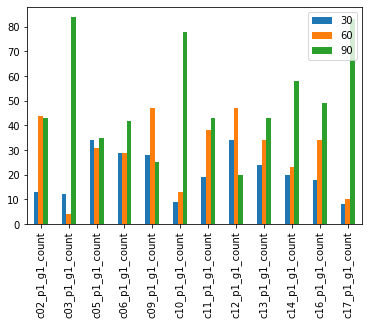

In [156]:
c_g1_counts_bar = c_g1_counts.plot.bar()

# save as jpeg
c_g1_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

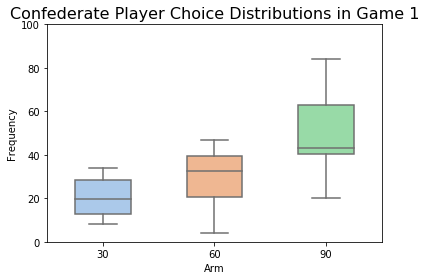

In [157]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("Confederate Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [158]:
#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

In [159]:
c_g1_low

20.666666666666668

In [160]:
c_g1_med

29.5

In [161]:
c_g1_high

50.25

In [162]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [163]:
c_g1_low_std

8.806563209081938

In [164]:
c_g1_med_std

13.793114224133722

In [165]:
c_g1_high_std

20.522853115490545

# Confederate choices in G2

In [166]:
c_g2_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])

In [167]:
#How to prevent NaN: df = df.fillna(0)
c_g2_counts = c_g2_counts.fillna(0)

#print
c_g2_counts

,30,60,90
c02_p1_g2_count,3,16,81
c03_p1_g2_count,5,12,83
c05_p1_g2_count,34,30,36
c06_p1_g2_count,36,35,30
c09_p1_g2_count,45,37,18
c10_p1_g2_count,11,24,65
c11_p1_g2_count,9,24,67
c12_p1_g2_count,38,45,18
c13_p1_g2_count,22,32,47
c14_p1_g2_count,19,30,52


In [168]:
c_g2_counts.sum(axis=1)

c02_p1_g2_count    100
c03_p1_g2_count    100
c05_p1_g2_count    100
c06_p1_g2_count    101
c09_p1_g2_count    100
c10_p1_g2_count    100
c11_p1_g2_count    100
c12_p1_g2_count    101
c13_p1_g2_count    101
c14_p1_g2_count    101
c16_p1_g2_count    101
c17_p1_g2_count    101
dtype: int64

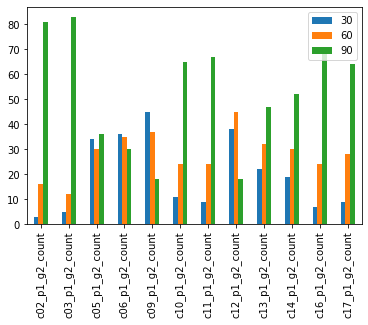

In [169]:
c_g2_counts_bar = c_g2_counts.plot.bar()

# save as jpeg
c_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

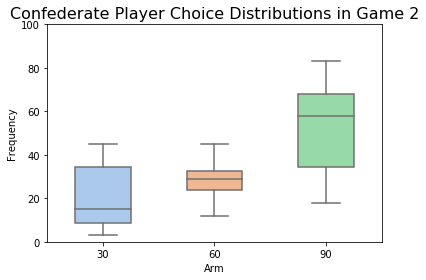

In [170]:
c_g2_counts_box = sns.boxplot( 
                 data=c_g2_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_counts_box.axes.set_title("Confederate Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="c_g2_counts_box.jpg"
 
plt.ylim(0, 100)
s=c_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [171]:
c_g2_low = np.mean(c_g2_counts.iloc[:,0])
c_g2_med = np.mean(c_g2_counts.iloc[:,1])
c_g2_high = np.mean(c_g2_counts.iloc[:,2])

In [172]:
c_g2_low

19.833333333333332

In [173]:
c_g2_med

28.083333333333332

In [174]:
c_g2_high

52.583333333333336

In [175]:
c_g2_low_std = np.std(c_g2_counts.iloc[:,0])
c_g2_med_std = np.std(c_g2_counts.iloc[:,1])
c_g2_high_std = np.std(c_g2_counts.iloc[:,2])

In [176]:
c_g2_low_std

14.176467198220516

In [177]:
c_g2_med_std

8.616441002847727

In [178]:
c_g2_high_std 

21.86495801251145

# Confederate arrays

In [179]:
#pip install researchpy

In [180]:
import researchpy as rp

In [181]:
c_90_1 = np.array(c_g1_counts.iloc[:,2])
c_90_2 = np.array(c_g2_counts.iloc[:,2])

In [182]:
c_90_1

array([43, 84, 35, 42, 25, 78, 43, 20, 43, 58, 49, 83])

In [183]:
c_90_2

array([81, 83, 36, 30, 18, 65, 67, 18, 47, 52, 70, 64])

In [184]:
c_60_1 = np.array(c_g1_counts.iloc[:,1])
c_60_2 = np.array(c_g2_counts.iloc[:,1])

In [185]:
c_60_1

array([44,  4, 31, 29, 47, 13, 38, 47, 34, 23, 34, 10])

In [186]:
c_60_2

array([16, 12, 30, 35, 37, 24, 24, 45, 32, 30, 24, 28])

In [187]:
c_30_1 = np.array(c_g1_counts.iloc[:,0])
c_30_2 = np.array(c_g2_counts.iloc[:,0])

In [188]:
c_30_1

array([13, 12, 34, 29, 28,  9, 19, 34, 24, 20, 18,  8])

In [189]:
c_30_2

array([ 3,  5, 34, 36, 45, 11,  9, 38, 22, 19,  7,  9])

# Confederate choice statistics

In [190]:
c_90_p = sp.stats.ttest_rel(c_90_1,c_90_2)
c_60_p = sp.stats.ttest_rel(c_60_1,c_60_2)
c_30_p = sp.stats.ttest_rel(c_30_1,c_30_2)

In [191]:
c_90_p

Ttest_relResult(statistic=-0.4756395153721154, pvalue=0.6436367555642966)

In [192]:
c_60_p

Ttest_relResult(statistic=0.3880896037406532, pvalue=0.7053550589949591)

In [193]:
c_30_p

Ttest_relResult(statistic=0.35541612894311325, pvalue=0.7289994056012533)

In [194]:
#maximizing and matching?

In [195]:
#maximizing and matching?

# CONTROL (total) scores in G1 and G2

In [196]:
#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1

,control_score_1
participant,
s01,60
s03,63
s05,77
s06,82
s07,63
s08,90
s09,65
s11,60
s12,83


In [197]:
#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


,control_score_2
participant,
s01,74
s03,71
s05,88
s06,87
s07,68
s08,80
s09,70
s11,61
s12,86


In [198]:
#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')

In [199]:
#label columns
control_scores.columns=['Game 1','Game 2']

In [200]:
control_scores

,Game 1,Game 2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


In [201]:
#export to excel
control_scores.to_excel("output13.xlsx")  

In [202]:
control_scores.sum(axis=1)

participant
s01    134
s03    134
s05    165
s06    169
s07    131
s08    170
s09    135
s11    121
s12    169
s15    163
s16    117
s17    157
s19    151
s20    122
c02    159
c03    152
c05    133
c06    112
c09    105
c10    160
c11    151
c12    112
c13    132
c14    131
c16    141
c17    159
dtype: int64

In [203]:
control_scores=control_scores.sum(axis=1)

In [204]:
control_scores.sort_values(inplace=True)

In [205]:
control_scores

participant
c09    105
c12    112
c06    112
s16    117
s11    121
s20    122
c14    131
s07    131
c13    132
c05    133
s01    134
s03    134
s09    135
c16    141
c11    151
s19    151
c03    152
s17    157
c02    159
c17    159
c10    160
s15    163
s05    165
s12    169
s06    169
s08    170
dtype: int64

In [206]:
control_scores_1_mean = control_scores_1.mean()

In [207]:
control_scores_1_mean

control_score_1    70.0
dtype: float64

In [208]:
control_scores_1_std = control_scores_1.std()

In [209]:
control_scores_1_std

control_score_1    9.87117
dtype: float64

In [210]:
control_scores_2_mean = control_scores_2.mean()

In [211]:
control_scores_2_mean

control_score_2    71.730769
dtype: float64

In [212]:
control_scores_2_std = control_scores_2.std()

In [213]:
control_scores_2_std

control_score_2    11.680951
dtype: float64

In [214]:
control_scores_med = control_scores.median()
control_scores_med

138.0

In [215]:
control_scores_p = sp.stats.ttest_rel(control_scores_1,control_scores_2)

In [216]:
control_scores_p

Ttest_relResult(statistic=array([-1.02339354]), pvalue=array([0.31592323]))

In [217]:
def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 / len(Y) - 1)
    return(df)

# Maximizing/Matching CONTROL

In [218]:
s_g1_counts

,30,60,90
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,35,36
s12_p1_g1_count,7,28,65
s15_p1_g1_count,10,12,79


In [219]:
s_g1_counts.sum(axis=1)

s01_p1_g1_count    100
s03_p1_g1_count    100
s05_p1_g1_count    100
s06_p1_g1_count    100
s07_p1_g1_count    100
s08_p1_g1_count    100
s09_p1_g1_count    100
s11_p1_g1_count    101
s12_p1_g1_count    100
s15_p1_g1_count    101
s16_p1_g1_count    101
s17_p1_g1_count    101
s19_p1_g1_count    100
s20_p1_g1_count    101
dtype: int64

In [220]:
s_g2_counts

,30,60,90
s01_p1_g2_count,38.0,16.0,46.0
s03_p1_g2_count,27.0,29.0,44.0
s05_p1_g2_count,11.0,0.0,89.0
s06_p1_g2_count,7.0,7.0,86.0
s07_p1_g2_count,18.0,32.0,50.0
s08_p1_g2_count,9.0,15.0,76.0
s09_p1_g2_count,14.0,37.0,49.0
s11_p1_g2_count,28.0,31.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s15_p1_g2_count,3.0,7.0,91.0


In [221]:
s_g2_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
s11_p1_g2_count    101.0
s12_p1_g2_count    100.0
s15_p1_g2_count    101.0
s16_p1_g2_count    101.0
s17_p1_g2_count    101.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

In [222]:
c_g1_counts

,30,60,90
c02_p1_g1_count,13,44,43
c03_p1_g1_count,12,4,84
c05_p1_g1_count,34,31,35
c06_p1_g1_count,29,29,42
c09_p1_g1_count,28,47,25
c10_p1_g1_count,9,13,78
c11_p1_g1_count,19,38,43
c12_p1_g1_count,34,47,20
c13_p1_g1_count,24,34,43
c14_p1_g1_count,20,23,58


In [223]:
c_g1_counts.sum(axis=1)

c02_p1_g1_count    100
c03_p1_g1_count    100
c05_p1_g1_count    100
c06_p1_g1_count    100
c09_p1_g1_count    100
c10_p1_g1_count    100
c11_p1_g1_count    100
c12_p1_g1_count    101
c13_p1_g1_count    101
c14_p1_g1_count    101
c16_p1_g1_count    101
c17_p1_g1_count    101
dtype: int64

In [224]:
c_g2_counts

,30,60,90
c02_p1_g2_count,3,16,81
c03_p1_g2_count,5,12,83
c05_p1_g2_count,34,30,36
c06_p1_g2_count,36,35,30
c09_p1_g2_count,45,37,18
c10_p1_g2_count,11,24,65
c11_p1_g2_count,9,24,67
c12_p1_g2_count,38,45,18
c13_p1_g2_count,22,32,47
c14_p1_g2_count,19,30,52


In [225]:
c_g2_counts.sum(axis=1)

c02_p1_g2_count    100
c03_p1_g2_count    100
c05_p1_g2_count    100
c06_p1_g2_count    101
c09_p1_g2_count    100
c10_p1_g2_count    100
c11_p1_g2_count    100
c12_p1_g2_count    101
c13_p1_g2_count    101
c14_p1_g2_count    101
c16_p1_g2_count    101
c17_p1_g2_count    101
dtype: int64

In [226]:
control_counts_g1 = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count,c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count','c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])


In [227]:
control_counts_g1

,30,60,90
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,35,36
s12_p1_g1_count,7,28,65
s15_p1_g1_count,10,12,79


In [228]:
control_counts_g2 = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count,c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count','c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])



In [229]:
control_counts_g2

,30,60,90
s01_p1_g2_count,38.0,16.0,46.0
s03_p1_g2_count,27.0,29.0,44.0
s05_p1_g2_count,11.0,NaN,89.0
s06_p1_g2_count,7.0,7.0,86.0
s07_p1_g2_count,18.0,32.0,50.0
s08_p1_g2_count,9.0,15.0,76.0
s09_p1_g2_count,14.0,37.0,49.0
s11_p1_g2_count,28.0,31.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s15_p1_g2_count,3.0,7.0,91.0


In [230]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.

In [231]:
#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d. *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

In [232]:
#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2

In [233]:
#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]


In [234]:
#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    rando = jsd(counts,random)
    soci = jsd(counts, social)
    return maxi,matchi,rando,soci

In [235]:
from scipy import stats

In [236]:
#if same, 0
#test = jsd(counts,maximize)

In [237]:
#test

In [238]:
def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    

In [239]:
#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([11, 0, 89])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd(s06_p1_g2_count)
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd(s17_p1_g1_count)
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0,22,78])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd(c03_p1_g1_count)
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd(c03_p1_g2_count)
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd(c10_p1_g2_count)
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc  = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd(c17_p1_g2_count)

NameError: name 'social' is not defined

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c02_g1_max, c03_g1_max, c05_g1_max, c06_g1_max, 
                                      c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c02_g1_match, c03_g1_match, c05_g1_match, c06_g1_match, 
                                      c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c02_g1_rand, c03_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c02_g1_soc, c03_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [ ]:
#closer to 0 = closer to that pure strategy
control_jsd_g1

In [ ]:
# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


In [ ]:
strategy_control_jsd_g1.value_counts()

In [ ]:
#control_types_g1 = check_type(control_jsd_g1)

In [ ]:
#control_types_g1.drop([0])

In [ ]:
#(control_types_g1 == 'maxi').sum()

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, 
                                      c09_g2_max, c10_g2_max, c11_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, 
                               s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, 
                                      c09_g2_match, c10_g2_match, c11_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, s11_g2_rand, s12_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, s11_g2_soc, s12_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, 
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [ ]:
control_jsd_g2

In [ ]:
# get the column name of min values in every row
strategy_control_jsd_g2 = control_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2)


In [ ]:
minValues_control_jsd_g2 = control_jsd_g2.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2)


In [ ]:
maxValues_control_jsd_g2 = control_jsd_g2.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2)



In [ ]:
strategy_control_jsd_g2.value_counts()

In [ ]:
#control_types_g2 = check_type(control_jsd_g2)

In [ ]:
#control_types_g2.drop([0])

In [ ]:
#(control_types_g2 == 'maxi').sum()

In [ ]:
#how different max and match dists are from eachother
#neither max or match(?)
#threshold = jsd(maximize,match)

In [ ]:
import matplotlib.lines as mlines

In [ ]:
#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

In [ ]:
import itertools

In [ ]:
#Here I print the means of the JSD values in each condition, just to see what they are.'''

In [ ]:
#run t test to see sig between max and match per game
#put in box plot
control_jsd_g1.mean()

In [ ]:
control_jsd_g1.std()

In [ ]:
control_jsd_g2.mean()

In [ ]:
control_jsd_g2.std()

# Control z-scores

In [ ]:
sp.stats.zscore(control_jsd_g1['max'])

In [ ]:
sp.stats.zscore(control_jsd_g2['max'])

In [ ]:
sp.stats.zscore(control_jsd_g1['match'])

In [ ]:
sp.stats.zscore(control_jsd_g2['match'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# if using a Jupyter notebook, inlcude:
%matplotlib inline

In [ ]:
mu = 0.217806 
sigma = 0.118674
x1 = 0.035604
x2 = 0.442841

In [ ]:
# calculate the z-transform
z1 = ( x1 - mu ) / sigma
z2 = ( x2 - mu ) / sigma

In [ ]:
x = np.arange(z1, z2, 0.001) # range of x in spec
x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y = norm.pdf(x,0,1)
y2 = norm.pdf(x_all,0,1)

In [ ]:
# build the plot
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fivethirtyeight')
ax.plot(x_all,y2)

ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.fill_between(x_all,y2,0, alpha=0.1)
ax.set_xlim([-4,4])
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_yticklabels([])
ax.set_title('Normal Gaussian Curve')

plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

# Control strategy stats 

In [ ]:
control_jsd_g1.dropna(inplace = True) 

# Max strategy

In [ ]:
control_max_g1 = control_jsd_g1.loc[ : , 'max' ]

In [ ]:
control_max_g1

In [ ]:
control_max_g2 = control_jsd_g2.loc[ : , 'max' ]

In [ ]:
control_max_g2

In [ ]:
control_max_g1_mean = control_max_g1.mean()

In [ ]:
control_max_g1_mean

In [ ]:
control_max_g1_std = control_max_g1.std()

In [ ]:
control_max_g1_std

In [ ]:
control_max_g2_mean = control_max_g2.mean()

In [ ]:
control_max_g2_mean

In [ ]:
control_max_g2_std = control_max_g2.std()
control_max_g2_std

Max T-Test 

In [ ]:
control_max_p = sp.stats.ttest_rel(control_max_g1,control_max_g2)

In [ ]:
control_max_p

# Match strategy

In [ ]:
control_match_g1 = control_jsd_g1.loc[ : , 'match' ]

In [ ]:
control_match_g1

In [ ]:
control_match_g2 = control_jsd_g2.loc[ : , 'match' ]

In [ ]:
control_match_g2

In [ ]:
control_match_g1_mean = control_match_g1.mean()

In [ ]:
control_match_g1_mean

In [ ]:
control_match_g1_std = control_match_g1.std()

In [ ]:
control_match_g1_std

In [ ]:
control_match_g2_mean = control_match_g2.mean()

In [ ]:
control_match_g2_mean

In [ ]:
control_match_g2_std = control_match_g2.std()

In [ ]:
control_match_g2_std

In [ ]:
control_match_p = sp.stats.ttest_rel(control_match_g1,control_match_g2)

In [ ]:
control_match_p

# Random strategy

In [ ]:
control_rand_g1 = control_jsd_g1.loc[ : , 'rand' ]

In [ ]:
control_rand_g1

In [ ]:
control_rand_g2 = control_jsd_g2.loc[ : , 'rand' ]

In [ ]:
control_rand_g2

In [ ]:
control_rand_g1_mean = control_rand_g1.mean()

In [ ]:
control_rand_g1_mean

In [ ]:
control_rand_g1_std = control_rand_g1.std()

In [ ]:
control_rand_g1_std

In [ ]:
control_rand_g2_mean = control_rand_g2.mean()

In [ ]:
control_rand_g2_mean

In [ ]:
control_rand_g2_std = control_rand_g2.std()
control_rand_g2_std

In [ ]:
control_rand_p = sp.stats.ttest_rel(control_rand_g1,control_rand_g2)

In [ ]:
control_rand_p

# Social strategy

In [ ]:
control_soc_g1 = control_jsd_g1.loc[ : , 'soc' ]

In [ ]:
control_soc_g1

In [ ]:
control_soc_g2 = control_jsd_g2.loc[ : , 'soc' ]

In [ ]:
control_soc_g2

In [ ]:
control_soc_g1_mean = control_soc_g1.mean()

In [ ]:
control_soc_g1_mean

In [ ]:
control_soc_g1_std = control_soc_g1.std()

In [ ]:
control_soc_g1_std

In [ ]:
control_soc_g2_mean = control_soc_g2.mean()

In [ ]:
control_soc_g2_mean

In [ ]:
control_soc_g2_std = control_soc_g2.std()

In [ ]:
control_soc_g2_std

In [ ]:
control_soc_p = sp.stats.ttest_rel(control_soc_g1,control_soc_g2)

In [ ]:
control_soc_p

In [ ]:
#control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])

In [ ]:
#control_scores_p

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
#,'orange','green','blue','pink','purple','peru','cyan','red','lightcoral','orange','darkorange','green','palegreen','blue', 'peru','cyan', 'red','lightcoral', 'orange','darkorange','green','palegreen','blue','palegreen','blue']

In [ ]:
#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_control_g1_ego = ['red','red','red','red','red','blue','red','red','red','red',
                         'red','blue','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g2_ego = ['red','red','blue','blue','red','red','red','red','blue','blue',
                         'red','red','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

colors_jsd_control_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
       #   'o','v','o','v','o','v','o','v']
colors

# Graphs

In [ ]:
#Here I try to plot the JSD Values. Continued below under 'JSD with gender.

In [ ]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

control_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)
plt.title('Control Egocentric Strategies Game 1', fontsize=18, y=1.05)
control_ego_jsd_g1_plot.plot(control_jsd_g1['max'], m*control_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()




In [ ]:
'''ontrol_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)

hist, xbins,ybins = control_ego_jsd_g1_plot.figure.histogram(y,x, bins=range(6))
x,y = np.meshgrid(xbins[:-1], ybins[:-1])
x = x[hist != 0]; y = y[hist != 0]
z   = hist[hist != 0]


fig, ax = plt.subplots()
ax.scatter(x,y, s=49, alpha=0.4)

for i in range(len(z)):
    ax.annotate(str(int(z[i])), xy=(x[i],y[i]), xytext=(4,0), 
                textcoords="offset points" )

plt.show()'''

In [ ]:

'''#under line = matching (closer to 0)
#plots of atual jsd values

m, b = np.polyfit(control_jsd_g1['rand'], control_jsd_g1['soc'], 1)

control_joint_jsd_g1_plot = control_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g1_joint)
plt.title('Control Social Strategies Game 1', fontsize=18, y=1.05)
control_joint_jsd_g2_plot.plot(control_jsd_g1['rand'], m*control_jsd_g1['soc'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_joint_jsd_g1_plot.add_line(line1)


F.set_figsize_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
Size = F.get_size_inches()
plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()



'''

In [ ]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2['max'], control_jsd_g2['match'], 1)

control_ego_jsd_g2_plot = control_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g2_ego)
plt.title('Control Egocentric Strategies Game 2', fontsize=18, y=1.05)
control_ego_jsd_g2_plot.plot(control_jsd_g2['max'], m*control_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()




In [ ]:
'''#under line = matching (closer to 0)
#plots of atual jsd values
control_joint_jsd_g2_plot = control_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g2_joint,title='Control Social Strategies Game 2')
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
control_joint_jsd_g2_plot.add_line(line1)



plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
control_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)'''

## Joint Analysis

In [ ]:
df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff = call_get_score(j01, 'j')
j01.head()

In [ ]:
df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff = call_get_score(j02, 'j')
j02.head()

In [ ]:
df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff = call_get_score(j03, 'j')
j03.head()

In [ ]:
df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff = call_get_score(j04, 'j')
j04.head()

In [ ]:
df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff = call_get_score(j05, 'j')
j05.head()

In [ ]:
df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff = call_get_score(j06, 'j')
j06.head()

In [ ]:
df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff = call_get_score(j07, 'j')
j07.head()

In [ ]:
df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff = call_get_score(j08, 'j')
j08.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/j10_gamedata.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff = call_get_score(j10, 'j')
j10.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/j11_gamedata.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff = call_get_score(j11, 'j')
j11.head()

In [ ]:
j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')


In [ ]:
j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

# Combined Joint scores G1

In [ ]:
j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'j_score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1

# Combined Joint scores G2

In [ ]:
j_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'j_score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2.set_index('participant', inplace=True, drop=True)
j_scores_2

In [ ]:
j_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')
j_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
j_scores

In [ ]:
j_scores_1_mean = j_scores_1.mean()

In [ ]:
j_scores_1_mean

In [ ]:
j_scores_1_std = j_scores_1.std()

In [ ]:
j_scores_1_std

In [ ]:
j_scores_2_mean = j_scores_2.mean()

In [ ]:
j_scores_2_mean

In [ ]:
j_scores_2_std = j_scores_2.std()

In [ ]:
j_scores_2_std

In [ ]:
j_scores_med = j_scores.median()
j_scores_med

In [ ]:
j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

In [ ]:
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("Joint Player Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
j_scores_p

# Joint combined choices in G1

In [ ]:
j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


In [ ]:
j_g1_counts = j_g1_counts.fillna(0)

In [ ]:
j_g1_counts 

In [ ]:
j_g1_counts.sum(axis=1)

In [ ]:
j_g1_counts_bar = j_g1_counts.plot.bar()

In [ ]:
j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Combined Joint Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

In [ ]:
j_g1_low

In [ ]:
j_g1_med

In [ ]:
j_g1_high

In [ ]:
j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])

In [ ]:
j_g1_low_std

In [ ]:
j_g1_med_std

In [ ]:
j_g1_high_std

# Joint combined choices in G2

In [ ]:
j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])


In [ ]:
j_g2_counts = j_g2_counts.fillna(0)
j_g2_counts 

In [ ]:
j_g2_counts.sum(axis=1)

In [ ]:
j_g2_counts_bar = j_g2_counts.plot.bar()

In [ ]:
j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Combined Joint Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

In [ ]:
j_g2_low

In [ ]:
j_g2_med

In [ ]:
j_g2_high

In [ ]:
j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])

In [ ]:
j_g2_low_std

In [ ]:
j_g2_med_std

In [ ]:
j_g2_high_std

# Joint combined arrays

In [ ]:
#pip install researchpy

In [ ]:
import researchpy as rp

In [ ]:
j_90_1 = np.array(j_g1_counts.iloc[:,2])
j_90_2 = np.array(j_g2_counts.iloc[:,2])

In [ ]:
j_90_1

In [ ]:
j_90_2

In [ ]:
j_60_1 = np.array(j_g1_counts.iloc[:,1])
j_60_2 = np.array(j_g2_counts.iloc[:,1])

In [ ]:
j_60_1

In [ ]:
j_60_2

In [ ]:
j_30_1 = np.array(j_g1_counts.iloc[:,0])
j_30_2 = np.array(j_g2_counts.iloc[:,0])

In [ ]:
j_30_1

In [ ]:
j_30_2

# Joint combined choice statistics

In [ ]:
j_90_p = sp.stats.ttest_rel(j_90_1,j_90_2)
j_60_p = sp.stats.ttest_rel(j_60_1,j_60_2)
j_30_p = sp.stats.ttest_rel(j_30_1,j_30_2)

In [ ]:
j_90_p

In [ ]:
j_60_p

In [ ]:
j_30_p

In [ ]:
#maximizing and matching?

# Multi Analysis

In [ ]:
df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_score_diff,m05_p2_score_diff = call_get_score(m05, 'm')
m05.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m06_gamedata.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_score_diff,m06_p2_score_diff = call_get_score(m06, 'm')
m06.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m08_gamedata.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_score_diff,m08_p2_score_diff = call_get_score(m08, 'm')
m08.head()

In [ ]:
#df = organize_trial_by_trial_floatclick('data/m09_gamedata.csv')
#m09 = df
#m09_p1_g1_score,m09_p1_g2_score,m09_p2_g1_score,m09_p2_g2_score,m09_p1_score_diff,m09_p2_score_diff = call_get_score(m09, 'm')
#m09.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m10_gamedata.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_score_diff,m10_p2_score_diff = call_get_score(m10, 'm')
m10.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m11_gamedata.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_score_diff,m11_p2_score_diff = call_get_score(m11, 'm')
m11.head()

In [ ]:
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m13_gamedata.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_score_diff,m13_p2_score_diff = call_get_score(m13, 'm')
m13.head()

In [ ]:
df = organize_trial_by_trial_floatclick('data/m14_gamedata.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_score_diff,m14_p2_score_diff = call_get_score(m14, 'm')
m14.head()

In [ ]:
m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')
m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

In [ ]:
m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

# Combined multi scores G1

In [ ]:
m_scores_1 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'm_score_1':
     [m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1

# Combined multi scores G2

In [ ]:
m_scores_2 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'm_score_1':
     [m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2.set_index('participant', inplace=True, drop=True)
m_scores_2

In [ ]:
m_scores = pd.merge(m_scores_1, m_scores_2, on = 'participant')
m_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
m_scores

In [ ]:
m_scores_1_mean = m_scores_1.mean()

In [ ]:
m_scores_1_mean

In [ ]:
m_scores_1_std = m_scores_1.std()

In [ ]:
m_scores_1_std

In [ ]:
m_scores_2_mean = m_scores_2.mean()

In [ ]:
m_scores_2_mean

In [ ]:
m_scores_2_std = m_scores_2.std()

In [ ]:
m_scores_2_std

In [ ]:
m_scores_med = m_scores.median()
m_scores_med

In [ ]:
m_scores_p = sp.stats.ttest_rel(m_scores['Game 1'],m_scores['Game 2'])

In [ ]:
m_scores_p

In [ ]:
m_scores_box = sns.boxplot( 
                 data=m_scores, 
                 width=0.5,
                 palette="pastel")
m_scores_box.axes.set_title("Multi Player Scores",
                    fontsize=16)

plot_file_name="m_score_box.jpg"
 
plt.ylim(0, 100)
m_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
m_scores_p

# Multi combined choices in G1

In [ ]:
m_g1_counts = pd.DataFrame([m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])


In [ ]:
m_g1_counts = m_g1_counts.fillna(0) 

In [ ]:
m_g1_counts

In [ ]:
m_g1_counts.sum(axis=1)

In [ ]:
m_g1_counts_bar = m_g1_counts.plot.bar()

In [ ]:
m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("Combined Multi Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])

In [ ]:
m_g1_low

In [ ]:
m_g1_med

In [ ]:
m_g1_high

In [ ]:
m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])

In [ ]:
m_g1_low_std

In [ ]:
m_g1_med_std

In [ ]:
m_g1_high_std

# Multi combined choices in G2

In [ ]:
m_g2_counts = pd.DataFrame([m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


In [ ]:
m_g2_counts = m_g2_counts.fillna(0) 

In [ ]:
m_g2_counts

In [ ]:
m_g2_counts.sum(axis=1)

In [ ]:
m_g2_counts_bar = m_g2_counts.plot.bar()

In [ ]:
m_g2_counts_box = sns.boxplot( 
                 data = m_g2_counts, 
                 width=0.5,
                 palette="pastel")
m_g2_counts_box.axes.set_title("Combined Multi Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="m_g2_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
m_g2_low = np.mean(m_g2_counts.iloc[:,0])
m_g2_med = np.mean(m_g2_counts.iloc[:,1])
m_g2_high = np.mean(m_g2_counts.iloc[:,2])

In [ ]:
m_g2_low

In [ ]:
m_g2_med

In [ ]:
m_g2_high

In [ ]:
m_g2_low_std = np.std(m_g2_counts.iloc[:,0])
m_g2_med_std = np.std(m_g2_counts.iloc[:,1])
m_g2_high_std = np.std(m_g2_counts.iloc[:,2])

In [ ]:
m_g2_low_std

In [ ]:
m_g2_med_std

In [ ]:
m_g2_high_std

# Multi combined arrays

In [ ]:
#pip install researchpy

In [ ]:
import researchpy as rp

In [ ]:
m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2 = np.array(m_g2_counts.iloc[:,2])

In [ ]:
m_90_1

In [ ]:
m_90_2

In [ ]:
m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2 = np.array(m_g2_counts.iloc[:,1])

In [ ]:
m_60_1

In [ ]:
m_60_2

In [ ]:
m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2 = np.array(m_g2_counts.iloc[:,0])

In [ ]:
m_30_1

In [ ]:
m_30_2

# Multi combined choice statistics

In [ ]:
m_90_p = sp.stats.ttest_rel(m_90_1,m_90_2)
m_60_p = sp.stats.ttest_rel(m_60_1,m_60_2)
m_30_p = sp.stats.ttest_rel(m_30_1,m_30_2)

In [ ]:
m_90_p

In [ ]:
m_60_p

In [ ]:
m_30_p

In [ ]:
#maximizing and matching?

# SOCIAL (total) scores G1

In [ ]:
social_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 
                                               'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 
                                               'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2','m05_p1', 'm05_p2','m06_p1', 
                                               'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 
                                               'm14_p1', 'm14_p2'], 'social_score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
social_scores_1.set_index('participant', inplace=True, drop=True)
social_scores_1


# SOCIAL (total) scores G2

In [ ]:
social_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1',
                        'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2', 
                           'm05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'social_score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score, m14_p1_g2_score, m14_p2_g2_score]})
social_scores_2.set_index('participant', inplace=True, drop=True)
social_scores_2

In [ ]:
social_scores = pd.merge(social_scores_1, social_scores_2, on = 'participant')
social_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
social_scores

In [ ]:
#export to excel
social_scores.to_excel("output14.xlsx")  

In [ ]:
social_scores=social_scores.sum(axis=1)

In [ ]:
social_scores.sort_values(inplace=True)

In [ ]:
social_scores

In [ ]:
social_scores_1_mean = social_scores_1.mean()

In [ ]:
social_scores_1_mean

In [ ]:
social_scores_1_std = social_scores_1.std()

In [ ]:
social_scores_1_std

In [ ]:
social_scores_2_mean = social_scores_2.mean()

In [ ]:
social_scores_2_mean

In [ ]:
social_scores_2_std = social_scores_2.std()

In [ ]:
social_scores_2_std

In [ ]:
social_scores_med = social_scores.median()
social_scores_med

In [ ]:
social_scores_p = sp.stats.ttest_rel(social_scores_1,social_scores_2)

In [ ]:
social_scores_p

# Arm1

In [ ]:
m05_p1_g1_arm = m05_p1_g1['arm'].value_counts(sort=False)
m05_p1_g2_arm = m05_p1_g2['arm'].value_counts(sort=False)
m05_p2_g1_arm = m05_p2_g1['arm'].value_counts(sort=False)
m05_p2_g2_arm = m05_p2_g2['arm'].value_counts(sort=False)
m06_p1_g1_arm = m06_p1_g1['arm'].value_counts(sort=False)
m06_p1_g2_arm = m06_p1_g2['arm'].value_counts(sort=False)
m06_p2_g1_arm = m06_p2_g1['arm'].value_counts(sort=False)
m06_p2_g2_arm = m06_p2_g2['arm'].value_counts(sort=False)
m08_p1_g1_arm = m08_p1_g1['arm'].value_counts(sort=False)
m08_p1_g2_arm = m08_p1_g2['arm'].value_counts(sort=False)
m08_p2_g1_arm = m08_p2_g1['arm'].value_counts(sort=False)
m08_p2_g2_arm = m08_p2_g2['arm'].value_counts(sort=False)
m10_p1_g1_arm = m10_p1_g1['arm'].value_counts(sort=False)
m10_p1_g2_arm = m10_p1_g2['arm'].value_counts(sort=False)
m10_p2_g1_arm = m10_p2_g1['arm'].value_counts(sort=False)
m10_p2_g2_arm = m10_p2_g2['arm'].value_counts(sort=False)
m11_p1_g1_arm = m11_p1_g1['arm'].value_counts(sort=False)
m11_p1_g2_arm = m11_p1_g2['arm'].value_counts(sort=False)
m11_p2_g1_arm = m11_p2_g1['arm'].value_counts(sort=False)
m11_p2_g2_arm = m11_p2_g2['arm'].value_counts(sort=False)
m13_p1_g1_arm = m13_p1_g1['arm'].value_counts(sort=False)
m13_p1_g2_arm = m13_p1_g2['arm'].value_counts(sort=False)
m13_p2_g1_arm = m13_p2_g1['arm'].value_counts(sort=False)
m13_p2_g2_arm = m13_p2_g2['arm'].value_counts(sort=False)
m14_p1_g1_arm = m14_p1_g1['arm'].value_counts(sort=False)
m14_p1_g2_arm = m14_p1_g2['arm'].value_counts(sort=False)
m14_p2_g1_arm = m14_p2_g1['arm'].value_counts(sort=False)
m14_p2_g2_arm = m14_p2_g2['arm'].value_counts(sort=False)
j01_p1_g1_arm = j01_p1_g1['arm'].value_counts(sort=False)
j01_p1_g2_arm = j01_p1_g2['arm'].value_counts(sort=False)
j01_p2_g1_arm = j01_p2_g1['arm'].value_counts(sort=False)
j01_p2_g2_arm = j01_p2_g2['arm'].value_counts(sort=False)
j02_p1_g1_arm = j02_p1_g1['arm'].value_counts(sort=False)
j02_p1_g2_arm = j02_p1_g2['arm'].value_counts(sort=False)
j02_p2_g1_arm = j02_p2_g1['arm'].value_counts(sort=False)
j02_p2_g2_arm = j02_p2_g2['arm'].value_counts(sort=False)
j03_p1_g1_arm = j03_p1_g1['arm'].value_counts(sort=False)
j03_p1_g2_arm = j03_p1_g2['arm'].value_counts(sort=False)
j03_p2_g1_arm = j03_p2_g1['arm'].value_counts(sort=False)
j03_p2_g2_arm = j03_p2_g2['arm'].value_counts(sort=False)
j04_p1_g1_arm = j04_p1_g1['arm'].value_counts(sort=False)
j04_p1_g2_arm = j04_p1_g2['arm'].value_counts(sort=False)
j04_p2_g1_arm = j04_p2_g1['arm'].value_counts(sort=False)
j04_p2_g2_arm = j04_p2_g2['arm'].value_counts(sort=False)
j05_p1_g1_arm = j05_p1_g1['arm'].value_counts(sort=False)
j05_p1_g2_arm = j05_p1_g2['arm'].value_counts(sort=False)
j05_p2_g1_arm = j05_p2_g1['arm'].value_counts(sort=False)
j05_p2_g2_arm = j05_p2_g2['arm'].value_counts(sort=False)
j06_p1_g1_arm = j06_p1_g1['arm'].value_counts(sort=False)
j06_p1_g2_arm = j06_p1_g2['arm'].value_counts(sort=False)
j06_p2_g1_arm = j06_p2_g1['arm'].value_counts(sort=False)
j06_p2_g2_arm = j06_p2_g2['arm'].value_counts(sort=False)
j07_p1_g1_arm = j07_p1_g1['arm'].value_counts(sort=False)
j07_p1_g2_arm = j07_p1_g2['arm'].value_counts(sort=False)
j07_p2_g1_arm = j07_p2_g1['arm'].value_counts(sort=False)
j07_p2_g2_arm = j07_p2_g2['arm'].value_counts(sort=False)
j08_p1_g1_arm = j08_p1_g1['arm'].value_counts(sort=False)
j08_p1_g2_arm = j08_p1_g2['arm'].value_counts(sort=False)
j08_p2_g1_arm = j08_p2_g1['arm'].value_counts(sort=False)
j08_p2_g2_arm = j08_p2_g2['arm'].value_counts(sort=False)
j10_p1_g1_arm = j10_p1_g1['arm'].value_counts(sort=False)
j10_p1_g2_arm = j10_p1_g2['arm'].value_counts(sort=False)
j10_p2_g1_arm = j10_p2_g1['arm'].value_counts(sort=False)
j10_p2_g2_arm = j10_p2_g2['arm'].value_counts(sort=False)
j11_p1_g1_arm = j11_p1_g1['arm'].value_counts(sort=False)
j11_p1_g2_arm = j11_p1_g2['arm'].value_counts(sort=False)
j11_p2_g1_arm = j11_p2_g1['arm'].value_counts(sort=False)
j11_p2_g2_arm = j11_p2_g2['arm'].value_counts(sort=False)

In [ ]:
social_arms_g1 = pd.DataFrame([j01_p1_g1_arm, j01_p2_g1_arm, j02_p1_g1_arm, j02_p2_g1_arm, j03_p1_g1_arm, 
              j03_p2_g1_arm, j04_p1_g1_arm, j04_p2_g1_arm, j05_p1_g1_arm, j05_p2_g1_arm, j06_p1_g1_arm, 
              j06_p2_g1_arm, j07_p1_g1_arm, j07_p2_g1_arm, j08_p1_g1_arm, j08_p2_g1_arm, 
              j10_p1_g1_arm, j10_p2_g1_arm, j11_p1_g1_arm, j11_p2_g1_arm, m05_p1_g1_arm, m05_p2_g1_arm, m06_p1_g1_arm, m06_p2_g1_arm, m08_p1_g1_arm, m08_p2_g1_arm, 
              m10_p1_g1_arm, m10_p2_g1_arm, m11_p1_g1_arm, m11_p2_g1_arm, m13_p1_g1_arm, m13_p2_g1_arm, 
              m14_p1_g1_arm, m14_p2_g1_arm],
                index = ['j01_p1_g1_arm', 'j01_p2_g1_arm', 'j02_p1_g1_arm', 'j02_p2_g1_arm', 
                 'j03_p1_g1_arm', 'j03_p2_g1_arm', 'j04_p1_g1_arm', 'j04_p2_g1_arm', 'j05_p1_g1_arm', 
                  'j05_p2_g1_arm', 'j06_p1_g1_arm', 'j06_p2_g1_arm', 'j07_p1_g1_arm', 
                    'j07_p2_g1_arm', 'j08_p1_g1_arm', 'j08_p2_g1_arm', 'j10_p1_g1_arm', 'j10_p2_g1_arm', 
                    'j11_p1_g1_arm', 'j11_p2_g1_arm', 'm05_p1_g1_arm', 'm05_p2_g1_arm', 'm06_p1_g1_arm', 'm06_p2_g1_arm',
                 'm08_p1_g1_arm', 'm08_p2_g1_arm', 'm10_p1_g1_arm', 'm10_p2_g1_arm', 'm11_p1_g1_arm', 
                'm11_p2_g1_arm', 'm13_p1_g1_arm', 'm13_p2_g1_arm', 'm14_p1_g1_arm', 'm14_p2_g1_arm'])

In [ ]:
#How to prevent NaN: df = df.fillna(0)
social_arms_g1 = social_arms_g1.fillna(0)

#print
social_arms_g1

In [ ]:
#export to excel
social_arms_g1.to_excel("output10.xlsx")  

In [ ]:
social_arms_g2 = pd.DataFrame([j01_p1_g2_arm, j01_p2_g2_arm, j02_p1_g2_arm, j02_p2_g2_arm, j03_p1_g2_arm, 
              j03_p2_g2_arm, j04_p1_g2_arm, j04_p2_g2_arm, j05_p1_g2_arm, j05_p2_g2_arm, j06_p1_g2_arm, 
              j06_p2_g2_arm, j07_p1_g2_arm, j07_p2_g2_arm, j08_p1_g2_arm, j08_p2_g2_arm, 
              j10_p1_g2_arm, j10_p2_g2_arm, j11_p1_g2_arm, j11_p2_g2_arm, m05_p1_g2_arm, m05_p2_g2_arm, m06_p1_g2_arm, m06_p2_g2_arm, m08_p1_g2_arm, m08_p2_g2_arm, 
              m10_p1_g2_arm, m10_p2_g2_arm, m11_p1_g2_arm, m11_p2_g2_arm, m13_p1_g2_arm, m13_p2_g2_arm, 
              m14_p1_g2_arm, m14_p2_g2_arm],
                index = ['j01_p1_g2_arm', 'j01_p2_g2_arm', 'j02_p1_g2_arm', 'j02_p2_g2_arm', 
                 'j03_p1_g2_arm', 'j03_p2_g2_arm', 'j04_p1_g2_arm', 'j04_p2_g2_arm', 'j05_p1_g2_arm', 
                  'j05_p2_g2_arm', 'j06_p1_g2_arm', 'j06_p2_g2_arm', 'j07_p1_g2_arm', 
                    'j07_p2_g2_arm', 'j08_p1_g2_arm', 'j08_p2_g2_arm', 'j10_p1_g2_arm', 'j10_p2_g2_arm', 
                    'j11_p1_g2_arm', 'j11_p2_g2_arm', 'm05_p1_g2_arm', 'm05_p2_g2_arm', 'm06_p1_g2_arm', 'm06_p2_g2_arm',
                 'm08_p1_g2_arm', 'm08_p2_g2_arm', 'm10_p1_g2_arm', 'm10_p2_g2_arm', 'm11_p1_g2_arm', 
                'm11_p2_g2_arm', 'm13_p1_g2_arm', 'm13_p2_g2_arm', 'm14_p1_g2_arm', 'm14_p2_g2_arm'])

In [ ]:
#How to prevent NaN: df = df.fillna(0)
social_arms_g2 = social_arms_g2.fillna(0)

#print
social_arms_g2

In [ ]:
social_arms_g2.to_excel("output11.xlsx")  

# Total social counts (Multi & Joint)

In [ ]:
social_counts_g1 = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])

In [ ]:
#How to prevent NaN: df = df.fillna(0)
social_counts_g1=social_counts_g1.fillna(0)

In [ ]:
social_counts_g1

In [ ]:
#export to excel
social_counts_g1.to_excel("output3.xlsx")  

In [ ]:
social_counts_g1.sum(axis = 0, skipna = True)

In [ ]:
social_counts_g1.mean(axis = 0)

In [ ]:
social_counts_g1.sum(axis=1)

In [ ]:
social_counts_g2 = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                    'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count', 'm05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])

In [ ]:
#How to prevent NaN: df = df.fillna(0)
social_counts_g2=social_counts_g2.fillna(0)
social_counts_g2

In [ ]:
#export to excel
social_counts_g2.to_excel("output4.xlsx")  

In [ ]:
social_counts_g2.sum(axis=1)

# Maximizing/Matching SOCIAL

In [ ]:
from scipy import stats

In [ ]:
#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


In [ ]:
#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi

In [ ]:
j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m05_p1_g1_max, m05_p2_g1_max, m06_p1_g1_max, m06_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                               m06_p1_g1_match, m06_p2_g1_match, m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m05_p1_g1_rand, m05_p2_g1_rand, m06_p1_g1_rand, m06_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m06_p1_g1_soc, m06_p2_g1_soc, m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [ ]:
#to print wothout truncation
pd.set_option('display.max_rows', None)

In [ ]:
social_jsd_g1

In [ ]:
#export to excel
social_jsd_g1.to_excel("output1.xlsx")  

In [ ]:
# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)


In [ ]:
strategy_social_jsd_g1.value_counts()

In [ ]:
#social_types_g1 = check_type(social_jsd_g1)

In [ ]:
#social_types_g1.drop([0])

In [ ]:
#(social_types_g1 == 'maxi').sum()

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m05_p1_g2_max, m05_p2_g2_max, m06_p1_g2_max, m06_p2_g2_max,
                                   m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m06_p1_g2_match, m06_p2_g2_match, m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m05_p1_g2_rand, m05_p2_g2_rand, m06_p1_g2_rand, m06_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m05_p1_g2_soc, m05_p2_g2_soc,
                               m06_p1_g2_soc, m06_p2_g2_soc, m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [ ]:
social_jsd_g2

In [ ]:
#export to excel
social_jsd_g2.to_excel("output2.xlsx")

In [ ]:
# get the column name of min values in every row
strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g2)


In [ ]:
strategy_social_jsd_g2.value_counts()

In [ ]:
social_jsd_g1.mean()

In [ ]:
social_jsd_g2.mean()

# Social strategy stats 

# Max strategy

In [ ]:
social_max_g1 = social_jsd_g1.loc[ : , 'max' ]

In [ ]:
social_max_g1

In [ ]:
social_max_g2 = social_jsd_g2.loc[ : , 'max' ]

In [ ]:
social_max_g2

In [ ]:
social_max_g1_mean = social_max_g1.mean()

In [ ]:
social_max_g1_mean

In [ ]:
social_max_g1_std = social_max_g1.std()

In [ ]:
social_max_g1_std

In [ ]:
social_max_g2_mean = social_max_g2.mean()

In [ ]:
social_max_g2_mean

In [ ]:
social_max_g2_std = social_max_g2.std()
social_max_g2_std

In [ ]:
social_max_p = sp.stats.ttest_rel(social_max_g1,social_max_g2)

In [ ]:
social_max_p

# Match strategy

In [ ]:
social_match_g1 = social_jsd_g1.loc[ : , 'match' ]

In [ ]:
social_match_g1

In [ ]:
social_match_g2 = social_jsd_g2.loc[ : , 'match' ]

In [ ]:
social_match_g2

In [ ]:
social_match_g1_mean = social_match_g1.mean()

In [ ]:
social_match_g1_mean

In [ ]:
social_match_g1_std = social_match_g1.std()

In [ ]:
social_match_g1_std

In [ ]:
social_match_g2_mean = social_match_g2.mean()

In [ ]:
social_match_g2_mean

In [ ]:
social_match_g2_std = social_match_g2.std()

In [ ]:
social_match_g2_std

In [ ]:
social_match_p = sp.stats.ttest_rel(social_match_g1,social_match_g2)

In [ ]:
social_match_p

# Random strategy

In [ ]:
social_rand_g1 = social_jsd_g1.loc[ : , 'rand' ]

In [ ]:
social_rand_g1

In [ ]:
social_rand_g2 = social_jsd_g2.loc[ : , 'rand' ]

In [ ]:
social_rand_g2

In [ ]:
social_rand_g1_mean = social_rand_g1.mean()

In [ ]:
social_rand_g1_mean

In [ ]:
social_rand_g1_std = social_rand_g1.std()

In [ ]:
social_rand_g1_std

In [ ]:
social_rand_g2_mean = social_rand_g2.mean()

In [ ]:
social_rand_g2_mean

In [ ]:
social_rand_g2_std = social_rand_g2.std()

In [ ]:
social_rand_g2_std

In [ ]:
social_rand_p = sp.stats.ttest_rel(social_rand_g1,social_rand_g2)

In [ ]:
social_rand_p

# Social strategy

In [ ]:
social_soc_g1 = social_jsd_g1.loc[ : , 'soc' ]

In [ ]:
social_soc_g1

In [ ]:
social_soc_g2 = social_jsd_g2.loc[ : , 'soc' ]

In [ ]:
social_soc_g2

In [ ]:
social_soc_g1_mean = social_soc_g1.mean()

In [ ]:
social_soc_g1_mean

In [ ]:
social_soc_g1_std = social_soc_g1.std()

In [ ]:
social_soc_g1_std

In [ ]:
social_soc_g2_mean = social_soc_g2.mean()

In [ ]:
social_soc_g2_mean

In [ ]:
social_soc_g2_std = social_soc_g2.std()

In [ ]:
social_soc_g2_std

In [ ]:
social_soc_p = sp.stats.ttest_rel(social_soc_g1,social_soc_g2)

In [ ]:
social_soc_p

In [ ]:
#social_types_g2 = check_type(social_jsd_g2)

In [ ]:
#social_types_g2.drop([0])

In [ ]:
#(social_types_g2 == 'maxi').sum()

In [ ]:
import matplotlib.lines as mlines

In [ ]:
#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

In [ ]:
import itertools

In [ ]:
#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_social_g1_egocentric = ['red','red','red','red','red','red','red',
                        'red','red','red', 'red','red','red','red',
              'red', 'red','red', 'red','red', 'blue','red','red',
                        'red','red','red','red', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g2_egocentric = ['red','red','red','red','red','blue','red',
                        'red','red','red', 'red','red','blue','red',
             'blue', 'red','red', 'red','red', 'blue','red','blue',
                        'red','red','red','blue', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']




colors_jsd_social_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']



#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
         # 'o','v','o','v','o','v','o','v']
colors

In [ ]:
#Here I print the means of the JSD values in each condition, just to see what they are.'''

In [ ]:
#run t test to see sig between max and match per game
#put in box plot
social_jsd_g1.mean()

In [ ]:
social_jsd_g2.mean()

In [ ]:
import matplotlib.patches as mpatches

# Graphs

In [ ]:
#Here I try to plot the JSD Values. Continued below under 'JSD with gender.

In [ ]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g1['max'], social_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g1_egocentric)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
social_ego_jsd_g1_plot.plot(social_jsd_g1['max'], m*social_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()




In [ ]:
#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g1_plot = social_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g1_joint,title='Multiplayer Social Strategies Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g1_plot.add_line(line1)



plt.savefig('social_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g1_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g2['max'], social_jsd_g2['match'], 1)

social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g2_egocentric)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
social_ego_jsd_g2_plot.plot(social_jsd_g2['max'], m*social_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()


In [ ]:
#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g2_plot = social_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g2_joint,title='Multiplayer Social Strategies Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g2_plot.add_line(line1)



plt.savefig('social_joint_jsd_2.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

# CONTROL (total) scores in G1 and G2

In [ ]:
#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1

In [ ]:
#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


In [ ]:
#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')

In [ ]:
#label columns
control_scores.columns=['Game 1','Game 2']

In [ ]:
control_scores

In [ ]:
control_scores_1_mean = control_scores_1.mean()

In [ ]:
control_scores_1_mean

In [ ]:
control_scores_1_std = control_scores_1.std()

In [ ]:
control_scores_1_std

In [ ]:
control_scores_2_mean = control_scores_2.mean()

In [ ]:
control_scores_2_mean

In [ ]:
control_scores_2_std = control_scores_2.std()

In [ ]:
control_scores_2_std

In [ ]:
control_scores_med = control_scores.median()
control_scores_med

In [ ]:
control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])

In [ ]:
control_scores_p

# End of SMAB3 analysis

In [ ]:
#hypothesis: scores lower for same gender pairs: male-male
'''here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can
do on the choice data, and you can group the data by demographics, questionnaire responses, etc.'''

In [ ]:
scores_f = pd.DataFrame([j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j04_p1_g1_score,
            j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,
            j07_p2_g2_score,j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score])

In [ ]:
scores_mix = pd.DataFrame([j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j02_p1_g1_score,
            j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,
            j05_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j06_p1_g1_score,
            j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score])

In [ ]:
#m_mean=scores_m.mean()
f_mean=scores_f.mean()
mix_mean=scores_mix.mean()

In [ ]:
#m_mean

In [ ]:
f_mean

In [ ]:
mix_mean

In [ ]:
j_combo = j_combo.sort_values(by=['participant'])

In [ ]:
#j_combo_bar = j_combo.plot(kind='bar',color=colors)

In [ ]:
j_score_diff = pd.DataFrame({'participant':['j01_p1','j01_p2','j02_p1','j02_p2','j03_p1','j03_p2','j04_p1','j04_p2',
                                          'j05_p1','j05_p2','j06_p1','j06_p2','j07_p1','j07_p2','j06_p1','j06_p2'], 'score_diff':
     [j01_p1_diff,j01_p2_diff,j02_p1_diff,j02_p2_diff,j03_p1_diff,j03_p2_diff,j04_p1_diff,j04_p2_diff,
     j05_p1_diff,j05_p2_diff,j06_p1_diff,j06_p2_diff,j07_p1_diff,j07_p2_diff,j08_p1_diff,j08_p2_diff]})

In [ ]:
j_score_diff

In [ ]:
#impairs learning?

In [ ]:
#pattern within sessions for score_diff?
#5 ppl did worse second time; joint interfered with learning

In [ ]:
j_score_diff_mean = j_score_diff['score_diff'].mean()

In [ ]:
j_score_diff_mean

In [ ]:
j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')

In [ ]:
#social matching

In [ ]:
j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, 
                            j03_p1_g2_count, j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count,
                           j05_p1_g2_count,j05_p2_g2_count, j06_p1_g2_count, j06_p2_g2_count, j07_p1_g2_count, 
                            j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                          index=['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                            'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count',
                           'j05_p1_g2_count','j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                            'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count'])

In [ ]:
j_g2_counts

In [ ]:
j_60_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,1],j_g2_counts.iloc[:,1])

In [ ]:
j_60_p

In [ ]:
j_30_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,0],j_g2_counts.iloc[:,0])

In [ ]:
j_30_p

In [ ]:
j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])

In [ ]:
j_g2_low

In [ ]:
j_g2_med

In [ ]:
j_g2_high

In [ ]:
j_g1_counts_bar = j_g1_counts.plot.bar()

In [ ]:
j_g2_counts_bar = j_g2_counts.plot.bar()

In [ ]:
j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"

plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"

plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
hannah_counts = pd.DataFrame([s08_p1_g1_count,s08_p1_g2_count,s09_p1_g1_count,s09_p1_g2_count,j01_p1_g1_count,
                              j01_p1_g2_count,j01_p2_g1_count,j01_p2_g2_count,j05_p1_g1_count,j05_p1_g2_count,j05_p1_g1_count,
                              j05_p2_g2_count],
                          index=['s08 Game 1','s08 Game 2','s09 Game 1','s09 Game 2','j01_1 Game 1','j01_1 Game 2',
                                'j01_2 Game 1','j01_2 Game 2','j05_1 Game 1','j05_1 Game 2','j05_2 Game 1','j05_2 Game 2'])

In [ ]:
hannah_counts

In [ ]:
hannah_counts.to_pickle('hannah_counts_table.pkl')

In [ ]:
hannah_counts_bar = hannah_counts.plot.bar(title='Choice Distributions')
plt.tight_layout()
plt.savefig('hannah_counts.eps',format='eps',dpi=1000)

# Combined Tables

In [ ]:
#NEEDS WORK
scores_df = pd.DataFrame({'score':[s_scores_1_mean, s_scores_2_mean, j_scores_1_mean, j_scores_2_mean],
                       'std':[s_scores_1_std,s_scores_2_std,j_scores_1_std,j_scores_2_std]},index = ['s_1','s_2',
                                                                                                     'j_1', 'j_2'])

In [ ]:
s_scores_1_mean

In [ ]:
pd.to_numeric(s_scores_1_mean)

In [ ]:
scores_df

In [ ]:
counts_df = pd.DataFrame({'low':[s_g1_low,s_g2_low,j_g1_low,j_g2_low],'medium':[s_g1_med,s_g2_med,j_g1_med,j_g2_med],
                          'high':[s_g1_high,s_g2_high,j_g1_high,j_g2_high]},index = ['s_1','s_2','j_1', 'j_2'])
#add standard deviations

In [ ]:
counts_df

In [ ]:
#j learn to favor medium over the low in game 2

In [ ]:
counts_std_df = pd.DataFrame({'low':[s_g1_low_std,s_g2_low_std,j_g1_low_std,j_g2_low_std],'medium':[s_g1_med_std,s_g2_med_std,j_g1_med_std,j_g2_med_std],
                          'high':[s_g1_high_std,s_g2_high_std,j_g1_high_std,j_g2_high_std]},index = ['s_1','s_2','j_1', 'j_2'])

In [ ]:
counts_std_df

In [ ]:
#high deviations in high and med in game 2
#evidence of 2 subgroups?

# Maximizing/Matching

In [ ]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.

In [ ]:
s_g1_counts

In [ ]:
s_g1_counts

In [ ]:
j_g1_counts

In [ ]:
j_g2_counts

In [ ]:
#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d. *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

In [ ]:
#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2

In [ ]:
#Idealized probability distributions to use for comparison. You can change these or add more models.
maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,50]

In [ ]:
#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize)
    matchi = jsd(counts,match)
    return maxi,matchi

In [ ]:
j01_p1_g1_count

In [ ]:
#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate.

social_max = [0, 100, 0]
social_match = [30/180 * 100,30/180 * 100, 30/180 * 100]

In [ ]:
#Calls jsd with the social distributions.
def call_jsd_social(counts):
    maxi = jsd(counts,social_max)
    matchi = jsd(counts,social_match)
    return maxi,matchi

In [ ]:
s01_p1_g1_count

In [ ]:
from scipy import stats

In [ ]:
#if same, 0
test = jsd(maximize,match)

In [ ]:
test

In [ ]:
s01 = 'match'

In [ ]:
s05_p1_g2_count

In [ ]:
s05_p1_g2_count = [11,0,89]

In [ ]:
# some add to 80, some add to 81??
s_g1_counts

In [ ]:
s_g2_counts

In [ ]:
#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match = call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match = call_jsd(s05_p1_g2_count)
s06_g1_max,s06_g1_match = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match = call_jsd(s06_p1_g1_count)
s07_g1_max,s07_g1_match = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match = call_jsd([0.0, 3.0, 78.0])
s17_g2_max,s17_g2_match = call_jsd([0, 19, 62])
s19_g1_max,s19_g1_match = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match = call_jsd(s20_p1_g2_count)

In [ ]:
s17_p1_g1_count

In [ ]:
s17_p1_g2_count

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
s_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, s19_g1_max, s20_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, s20_g1_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [ ]:
#closer to 0 = closer to that pure strategy
s_jsd_g1

In [ ]:
#Create a dataframe for single player game 2 jsd scores, with a column for each strategy.'''
s_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, s19_g2_max, s20_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, s20_g2_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [ ]:
def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    for index,row in df.iterrows():
        maxi = row["max"]
        matchi = row["match"]
        print(index,maxi,matchi)
        if maxi < matchi:
            print('maxi')
            types = types.append({'type' : 'maxi'},ignore_index=True)
            #types[index,'type'] = 'max'
            num = maxi
        elif matchi < maxi:
            print('matchi')
            types = types.append({'type' : 'matchi'},ignore_index=True)
            num = matchi
        else:
            types = types.append({'type' : 'neither'},ignore_index=True)
            num = 1
        if social == True:
            if num >= jsd(social_max,social_match):
                types = types.append({'type' : 'neither'},ignore_index=True)
        else:
            if num >= jsd(maximize,match):
                types = types.append({'type' : 'neither'},ignore_index=True)
    return types

In [ ]:
s_types_g1 = check_type(s_jsd_g1)

In [ ]:
s_types_g2 = check_type(s_jsd_g2)

In [ ]:
#add label, make sure in correct order
s_types_g1.drop([0])

In [ ]:
s_types_g2.drop([0])

In [ ]:
#how different max and match dists are from eachother
#neither max or match(?)
threshold = jsd(maximize,match)

In [ ]:
threshold

In [ ]:
s_jsd_g1

In [ ]:
s_jsd_g2

In [ ]:
#Call 'call_jsd' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd([0,6,74])
j11_p1_g2_max,j11_p1_g2_match = call_jsd([0,6,74])
j11_p2_g1_max,j11_p2_g1_match = call_jsd([0,6,74])
j11_p2_g2_max,j11_p2_g2_match = call_jsd([0,6,74])

In [ ]:
#Create a dataframe for joint game 1 jsd scores, with a column for each strategy.'''
j_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max,j10_p1_g1_max,j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
#Create a dataframe for joint game 2 jsd scores, with a column for each strategy.'''
j_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,j10_p1_g2_max,j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match,j10_p1_g2_match,
                              j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
j_types_g1 = check_type(j_jsd_g1)

In [ ]:
j_types_g2 = check_type(j_jsd_g2)

In [ ]:
j_types_g1.drop([0])

In [ ]:
j_types_g2.drop([0])

In [ ]:
j_jsd_g1

In [ ]:
j_jsd_g2

In [ ]:
#same for joint using "social"

In [ ]:
#Call 'call_jsd_social' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd_social(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd_social(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd_social(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd_social(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd_social(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd_social(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd_social(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd_social(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd_social(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd_social(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd_social(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd_social(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd_social(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd_social(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd_social(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd_social(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd_social(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd_social(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd_social(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd_social(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd_social(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd_social(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd_social(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd_social(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd_social(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd_social(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd_social(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd_social(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd_social(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd_social(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd_social(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd_social(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd_social(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd_social(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd_social(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd_social(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd_social(j11_p1_g1_count)
j11_p1_g2_max,j11_p1_g2_match = call_jsd_social(j11_p1_g2_count)
j11_p2_g1_max,j11_p2_g1_match = call_jsd_social(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match = call_jsd_social(j11_p2_g2_count)

In [ ]:
#Create a dataframe for joint game 1 social jsd scores, with a column for each strategy.'''
j_jsd_g1_social = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
#Create a dataframe for joint game 2 social jsd scores, with a column for each strategy.'''
j_jsd_g2_social = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08'])

In [ ]:
j_jsd_g1_social = check_type(j_jsd_g1_social,True)

In [ ]:
j_jsd_g2_social = check_type(j_jsd_g2_social,True)

In [ ]:
#j_jsd_g1_social.drop([0])

j_jsd_g1_social

In [ ]:
j_jsd_g2_social

In [ ]:
threshold

In [ ]:
import matplotlib.lines as mlines

In [ ]:
#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

In [ ]:
import itertools

In [ ]:
#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
colors_jsd_j = ['red','lightcoral','orange','darkorange','green','palegreen',
              'blue','darkblue','hotpink','pink','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_s_g1 = ['red','orange','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
colors_jsd_s_g2 = ['red','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
          'o','v','o','v','o','v','o','v']
colors

In [ ]:
#Here I print the means of the JSD values in each condition, just to see what they are.'''

In [ ]:
#run t test to see sig between max and match per game
#put in box plot
s_jsd_g1.mean()

In [ ]:
s_jsd_g2.mean()

In [ ]:
j_jsd_g1.mean()

In [ ]:
j_jsd_g2.mean()

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
#create proxy artist for legend
patches = []
for index,row in j_jsd_g1.iterrows():
    for i in colors_jsd_j:
        patches.append(mpatches.Patch(color=i, label=index))

# legend not working

In [ ]:
#Here I try to plot the JSD Values. Continued below under 'JSD with gender.

In [ ]:
#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g1_plot = plt.subplots()

j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()




#color code pairs together



In [ ]:
#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g2_plot = plt.subplots()


j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')
line1 = mlines.Line2D([-1, 0.4],[-1, 0.4], color='red')
#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g2_plot.add_line(line1)
#j_jsd_g2_plot.add_line(line2)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()


#color code pairs together

In [ ]:
#under line = matching (closer to 0)
#plots of atual jsd values
s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))

#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g2_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)

In [ ]:
threshold_social = jsd(social_max,social_match)

In [ ]:
threshold_social

In [ ]:
j_jsd_g1_social_plot = j_jsd_g1_social.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multi Player JSD Social Values Game 1')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
#line1 = mlines.Line2D([0.3183, 0.3183],[-0.03, 0.55], color='red')
#line2 = mlines.Line2D([0, 0.8],[0.3183, 0.3183])
#j_jsd_g1_social_plot.add_line(line1)
#j_jsd_g1_social_plot.add_line(line2)

line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g1_social_plot.add_line(line1)
plt.savefig('j_jsd_social_1.eps',format='eps',dpi=1000)
#everyone could be classified as a matcher. everyone to the left of the red line could be using both
#NEED TO: color differently those who were more of maximizers than matchers!!!

In [ ]:
j_jsd_g2_social_plot = j_jsd_g2_social.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_j,title='Multi Player JSD Social Values Game 2')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g2_social_plot.add_line(line1)
plt.savefig('j_jsd_social_2.eps',format='eps',dpi=1000)

### NOT WORKING
def check_type_3(row):
        maxi = row["max"]
        matchi = row["match"]
        if maxi < matchi:
            row['type'] = 'max'
            num = maxi
        elif matchi < maxi:
            row['type'] = 'match'
            num = matchi
        else:
            row['type'] = 'neither'
        if num >= jsd(maximize,match):
            row['type'] = 'neither'
            
def check_type_2(df):
    for row in df.itertuples(index=True, name='Pandas'):
        print(index,row["max"],row["match"])
        if row["match"] < row["max"] and row["match"] < jsd(maximize,match):
            df.at[index,'type'] = 'match'
        elif row["max"] < row["match"] and row["max"] < jsd(maximize,match):
            df.at[index,'type'] = 'max'
        else:
            df.at[index,'type'] = 'neither'

# Gender Diff

In [ ]:
#load from CSV file
reader = csv.reader( open('gender.csv'))
data = [row for row in reader]
gender = pd.DataFrame(np.array(data))
gender = gender.rename(columns = {0:"participant", 1:"gender "})
gender_s = gender.iloc[16:,:]
gender_j = gender.iloc[:16,:]
gender_s.drop([19])

In [ ]:
gender_s

In [ ]:
gender_j

In [ ]:
gender_s = gender_s.merge(s_scores_1,on='participant')

In [ ]:
gender_s = gender_s.merge(s_scores_2,on='participant')

In [ ]:
gender_s
#gender_s.drop(['score'],axis=1)

In [ ]:
gender_s = gender_s.merge(score_diff,on='participant')

In [ ]:
gender_s

In [ ]:
#gender_s_m = gender_s.gender == "male"
#gender_s['score_x'].mean()

In [ ]:
j_scores_1['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']
j_scores_2['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']

In [ ]:
j_score_diff['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']

In [ ]:
j_score_diff

In [ ]:
gender_j = gender_j.merge(j_scores_1,on='participant')
#gender_j = gender_j.merge(j_scores_2,on='participant')
#gender_j = gender_j.merge(j_score_diff,on='participant')

In [ ]:
gender_j

In [ ]:
gender_j = gender_j.merge(j_scores_2,on='participant')

In [ ]:
gender_j

In [ ]:
gender_j = gender_j.merge(j_score_diff,on='participant')

In [ ]:
gender_j

In [ ]:
#don't remove first 20 trials
def organize_trial_by_trial_all(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.apply(pd.to_numeric)
    df.head()
    
    #combining info in the same trial for both players together in the same row
    #player1 = df[df['player'] == 1].drop(columns = "P2 score").drop(columns = "player")
    #player1 = player1.reset_index().drop(columns = "index")
    #player1 = player1.rename(columns = {"arm":"P1 arm", "probability":"P1 prob", "reward":"P1 reward"})

    #player2 = df[df['player'] == 2].drop(columns = "P1 score").drop(columns = 'trial').drop(columns = 'player')
    #player2 = player2.reset_index().drop(columns = "index")
    #player2 = player2.rename(columns = {"arm":"P2 arm", "probability":"P2 prob", "reward":"P2 reward"})

    #result = pd.concat([player1, player2], axis=1, sort=False)
    return df

In [ ]:
#don't remove first 20 trials
#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    #remove first 20 trials for g2
    #df_p1_g2 = df_p1_g2[20:]
    if version == 's':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [ ]:
import glob,os

In [ ]:
for filename in glob.iglob('/data/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        filename = organize_trial_by_trial_all(filename)

# jsd with gender

In [ ]:
colors_jsd_s_g1=['b','b','r','b','b','r','r','r']
colors_jsd_s_g2=['b','r','b','b','r','r','r']

In [ ]:
s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g1,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
colors_jsd_j = ['purple','green','green','purple','r','r','r','r','purple','green','green','purple','r','r','r','r']

In [ ]:
#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')

line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])


j_jsd_g2_plot.add_line(line1)


#plt.legend(handles=patches)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()